In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve, roc_auc_score
from scipy.stats import zscore, iqr
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Create a synthetic dataset with normal and anomalous data
np.random.seed(42)
normal_data = np.random.normal(loc=50, scale=5, size=(1000, 2))
anomalous_data = np.random.normal(loc=70, scale=5, size=(50, 2))
data = np.vstack((normal_data, anomalous_data))

# Create labels (0 for normal, 1 for anomalies)
labels = np.array([0] * 1000 + [1] * 50)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Feature1", "Feature2"])
df["Anomaly"] = labels

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["Feature1", "Feature2"]])


In [2]:
# Compute Z-scores
df["Z_Score1"] = zscore(df["Feature1"])
df["Z_Score2"] = zscore(df["Feature2"])

# Identify anomalies using threshold (|Z| > 3)
df["Z_Score_Anomaly"] = ((np.abs(df["Z_Score1"]) > 3) | (np.abs(df["Z_Score2"]) > 3)).astype(int)

# Compute IQR
Q1 = df[["Feature1", "Feature2"]].quantile(0.25)
Q3 = df[["Feature1", "Feature2"]].quantile(0.75)
IQR_values = Q3 - Q1

# Identify anomalies using IQR threshold
df["IQR_Anomaly"] = ((df["Feature1"] < (Q1["Feature1"] - 1.5 * IQR_values["Feature1"])) |
                      (df["Feature1"] > (Q3["Feature1"] + 1.5 * IQR_values["Feature1"])) |
                      (df["Feature2"] < (Q1["Feature2"] - 1.5 * IQR_values["Feature2"])) |
                      (df["Feature2"] > (Q3["Feature2"] + 1.5 * IQR_values["Feature2"]))).astype(int)


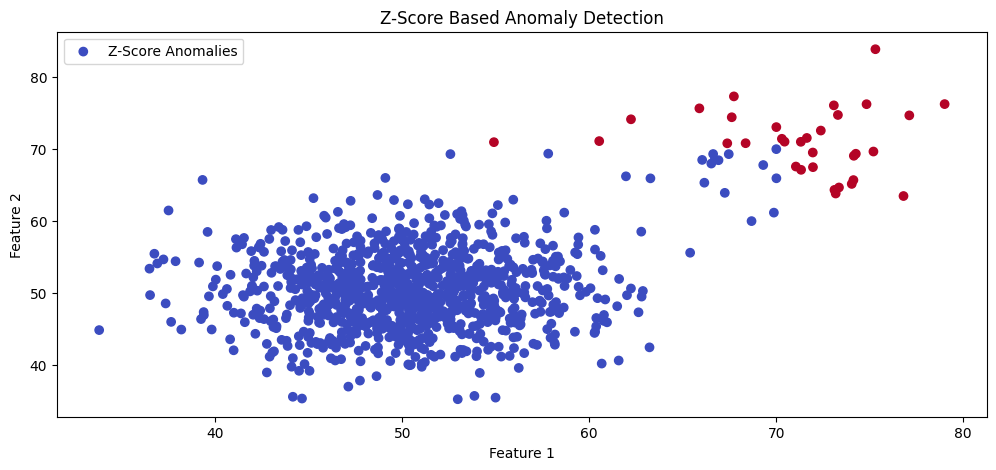

In [3]:
plt.figure(figsize=(12, 5))
plt.scatter(df["Feature1"], df["Feature2"], c=df["Z_Score_Anomaly"], cmap="coolwarm", label="Z-Score Anomalies")
plt.title("Z-Score Based Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


In [4]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
principal_components = pca.transform(df_scaled)

# Reconstruction error
reconstruction = pca.inverse_transform(principal_components)
error = np.sum((df_scaled - reconstruction) ** 2, axis=1)

# Set threshold for anomalies
threshold = np.percentile(error, 98)
df["PCA_Anomaly"] = (error > threshold).astype(int)


In [6]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["Isolation_Forest_Anomaly"] = iso_forest.fit_predict(df_scaled)
df["Isolation_Forest_Anomaly"] = df["Isolation_Forest_Anomaly"].apply(lambda x: 1 if x == -1 else 0)


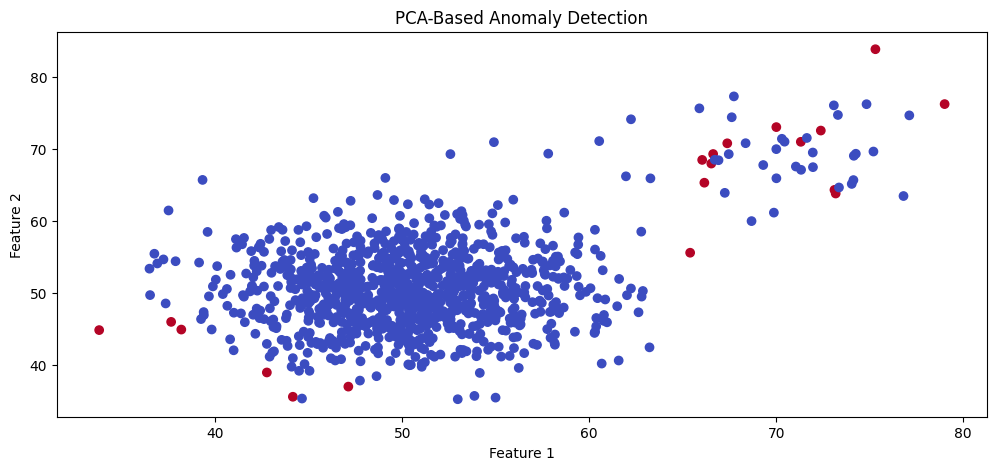

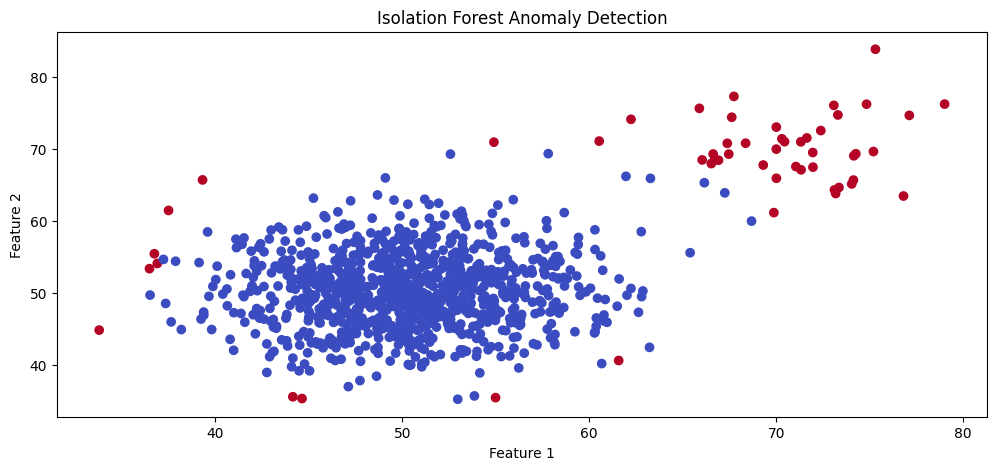

In [7]:
plt.figure(figsize=(12, 5))
plt.scatter(df["Feature1"], df["Feature2"], c=df["PCA_Anomaly"], cmap="coolwarm")
plt.title("PCA-Based Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

plt.figure(figsize=(12, 5))
plt.scatter(df["Feature1"], df["Feature2"], c=df["Isolation_Forest_Anomaly"], cmap="coolwarm")
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [8]:
# Define Autoencoder architecture
input_layer = Input(shape=(2,))
encoded = Dense(4, activation="relu")(input_layer)
decoded = Dense(2, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train the autoencoder
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Compute reconstruction error
df["Autoencoder_Reconstruction"] = np.sum((df_scaled - autoencoder.predict(df_scaled)) ** 2, axis=1)

# Set anomaly threshold
threshold = np.percentile(df["Autoencoder_Reconstruction"], 98)
df["Autoencoder_Anomaly"] = (df["Autoencoder_Reconstruction"] > threshold).astype(int)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


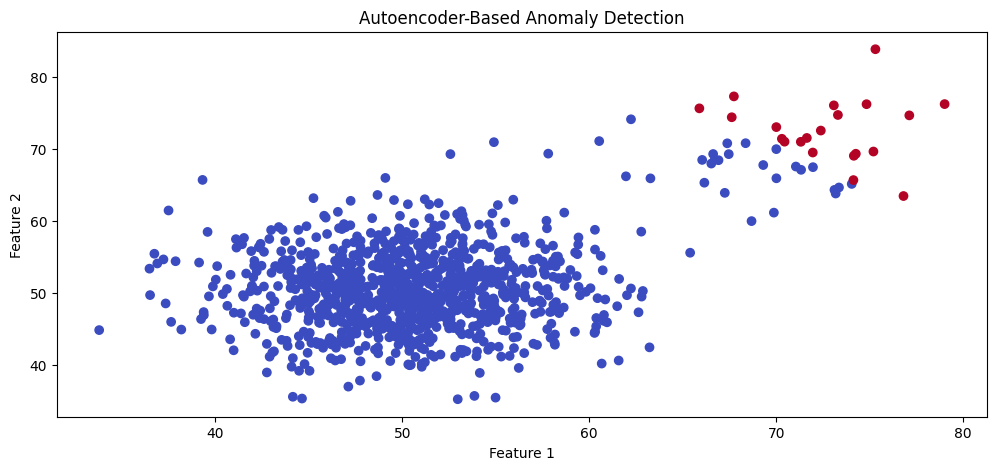

In [9]:
plt.figure(figsize=(12, 5))
plt.scatter(df["Feature1"], df["Feature2"], c=df["Autoencoder_Anomaly"], cmap="coolwarm")
plt.title("Autoencoder-Based Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


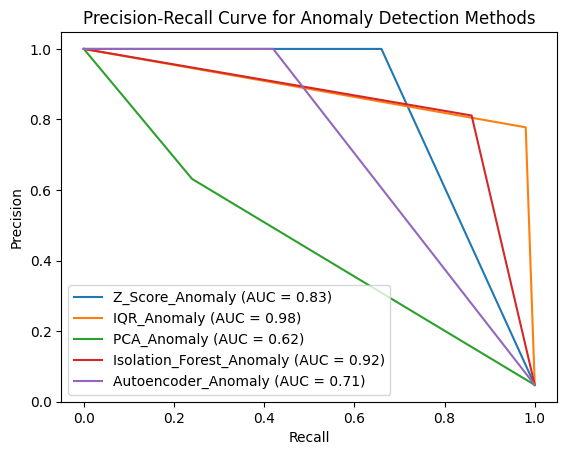

In [10]:
methods = ["Z_Score_Anomaly", "IQR_Anomaly", "PCA_Anomaly", "Isolation_Forest_Anomaly", "Autoencoder_Anomaly"]

for method in methods:
    precision, recall, _ = precision_recall_curve(df["Anomaly"], df[method])
    auc_score = roc_auc_score(df["Anomaly"], df[method])

    plt.plot(recall, precision, label=f"{method} (AUC = {auc_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Anomaly Detection Methods")
plt.legend()
plt.show()


In [11]:
summary = pd.DataFrame({
    "Method": methods,
    "Anomalies Detected": [df[m].sum() for m in methods],
    "AUC Score": [roc_auc_score(df["Anomaly"], df[m]) for m in methods]
})

print(summary)


                     Method  Anomalies Detected  AUC Score
0           Z_Score_Anomaly                  33     0.8300
1               IQR_Anomaly                  63     0.9830
2               PCA_Anomaly                  19     0.6165
3  Isolation_Forest_Anomaly                  53     0.9250
4       Autoencoder_Anomaly                  21     0.7100
